# ResNetClassifier: Medical Image Classification Based on ResNet50V2

In [1]:
#!pip install tensorflow
import os
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from IPython.display import clear_output
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50, ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score, roc_curve
from livelossplot import PlotLossesKeras
from keras.models import load_model, Model
from keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from keras import backend as K

# Constants and Hyperparameters

In [2]:
# Define hyperparameters and constants
BATCH_SIZE = 64
EPOCHS = 50
LEARN_RATE = 0.001
NEURONS = 256

MEAN = 0.136
STD = 0.178

IM_SIZE = 288
DATASET = 'dataset_UWM_GI_Tract_classification_rgb_test15'

# Evaluation Functions

In [13]:
# Function for custom normalization
def custom_normalization(image):
    image = image / 255.0
    image = (image - MEAN) / STD
    return image

# ploting model loss during training, created by Daniel: https://medium.com/geekculture/how-to-plot-model-loss-while-training-in-tensorflow-9fa1a1875a5
class plot_learning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

def roc_curve_tf(y_true, y_pred):
    thresholds, idx = tf.unique(tf.concat([y_pred, tf.constant([1.0], dtype=y_pred.dtype)], axis=0))
    thresholds = thresholds[:-1]
    thresholds = tf.reverse(thresholds, axis=[0])

    y_true_sorted = tf.gather(y_true, idx)
    num_positives = tf.reduce_sum(y_true)
    num_negatives = tf.reduce_sum(1 - y_true)

    tprs = tf.cumsum(y_true_sorted) / num_positives
    fprs = tf.cumsum(1 - y_true_sorted) / num_negatives

    return fprs, tprs, thresholds


def find_roc_threshold_tpr(y, y_pred, value_target):
    """
    This function calculates the threshold and false positive rate corresponding to a true positive rate of value_target (from 0 to 1).
       
    y                     # Real labels
    y_pred                # Predicted labels
    value_target          # False positive rate value
    
    Returns:
    
    threshold             # Threshold value
    true_positive_rate   # True positive rate value
    """

    #y_pred = tf.squeeze(y_pred)
    #fpr, tpr, thr = roc_curve_tf(y, y_pred)

    #old_diff = 100000000
    #for index, value in enumerate(tpr):
    #    new_diff = abs(value_target - value)
    #    if new_diff < old_diff:
    #        false_pos_rate = fpr[index]
    #        threshold = thr[index]
    #        old_diff = new_diff
    #return threshold, false_pos_rate

    # Assuming y and y_pred are TensorFlow tensors
    y_np = y.numpy() if tf.executing_eagerly() else y.numpy()
    y_pred_np = y_pred.numpy() if tf.executing_eagerly() else y_pred.numpy()
    
    # Call roc_curve from scikit-learn with NumPy arrays
    fpr, tpr, thr = roc_curve(y_np, y_pred_np)

    #fpr, tpr, thr = roc_curve(tf.cast(y, tf.float32), tf.cast(y_pred, tf.float32))

    # Convert TensorFlow tensors to NumPy arrays when necessary
    #with tf.Session() as sess:
    #    fpr = fpr.numpy()
    #    tpr = tpr.numpy()
    #    thr = thr.numpy()
    
    idx = tf.argmax(tf.cast(tpr >= value_target, tf.int32))
    threshold = thr[idx]
    return threshold, fpr[idx]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges,
                          figsize=(10,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    # Confusion matrix
    #cm = confusion_matrix(test_labels, rf_predictions)
    #plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
    #                      title = 'Health Confusion Matrix')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    # Plot the confusion matrix
    plt.figure(figsize = figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    #plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

def recall_loss(ground_truths, predictions):
    true_07 = predictions > 0.07652711868286133    
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(ground_truths * tf.cast(true_07, tf.float32), 0, 1)))
    #true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(ground_truths * predictions, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(ground_truths, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())    
    #recall_05 = true_positives_05 / (possible_positives + tf.keras.backend.epsilon())    
    #recall_02 = true_positives_02 / (possible_positives + tf.keras.backend.epsilon())
    #recall_01 = true_positives_01 / (possible_positives + tf.keras.backend.epsilon())    
    #recall_00 = true_positives_00 / (possible_positives + tf.keras.backend.epsilon())    
    
    CE = tf.keras.losses.binary_crossentropy(ground_truths, predictions)
    #CE = F.cross_entropy(predictions, ground_truths)    
    return -tf.math.log(recall*recall) + CE
    #return (((1.0 - recall_02) + (1.0 - recall_01) + (1.0 - recall_00)) / 3) + CE
    
def fpr_loss(ground_truths, predictions):
#    _, false_positive_rate = find_roc_threshold_tpr(ground_truths., predictions, 0.995)
    # predictions_binary = predictions > thr
    # true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(ground_truths * predictions_binary, 0, 1)))
    # possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(ground_truths, 0, 1)))
    # recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
#    logFPR = -tf.math.log(1 - false_positive_rate)
#    CE = tf.keras.losses.binary_crossentropy(ground_truths, predictions)
#    return logFPR + CE
    threshold, false_positive_rate = find_roc_threshold_tpr(tf.cast(ground_truths, tf.float32), tf.cast(predictions, tf.float32), 0.995)
    predictions_binary = tf.cast(predictions >= threshold, tf.float32)
    logFPR = -tf.math.log(1 - false_positive_rate)
    CE = tf.keras.losses.binary_crossentropy(ground_truths, predictions_binary)
    return logFPR + CE

# Binary Classification Model

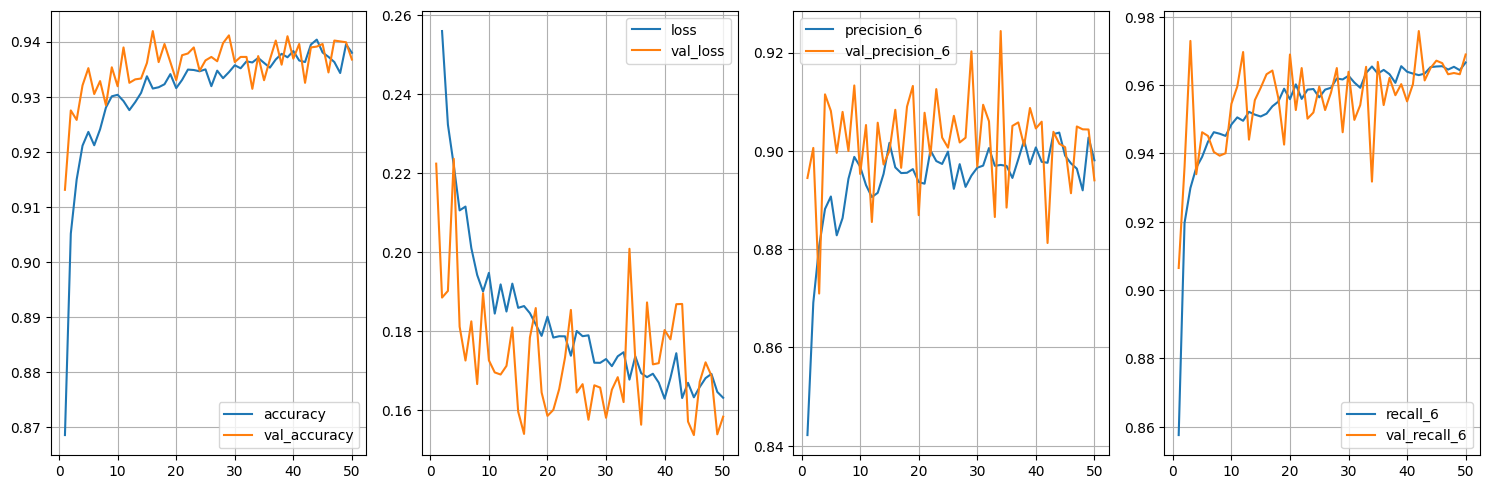

400/400 ━━━━━━━━━━━━━━━━━━━━ 1250s 3s/step - accuracy: 0.9374 - loss: 0.1663 - precision_6: 0.8984 - recall_6: 0.9652 - val_accuracy: 0.9367 - val_loss: 0.1583 - val_precision_6: 0.8940 - val_recall_6: 0.9689


In [15]:
# Preprocess the images and create data generators with augmentation and normalization
train_datagen = ImageDataGenerator(
    preprocessing_function = custom_normalization,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],  # Adjust brightness randomly between 0.5 and 1.5
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    preprocessing_function = custom_normalization)

train_generator = train_datagen.flow_from_directory(
    DATASET + '/train',
    target_size=(IM_SIZE, IM_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    DATASET + '/train',
    target_size=(IM_SIZE, IM_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    DATASET + '/test',
    target_size=(IM_SIZE, IM_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Load the pre-trained ResNet50V2 model
#wgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))
resnet_base = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))

# Freeze the layers in the base model
for layer in resnet_base.layers:
    layer.trainable = False

# Get the output tensor of the base ResNet50V2 model
resnet_output = resnet_base.output

# Flatten the output tensor
flattened_output = Flatten()(resnet_output)

# Add the fully connected layers: 1 layer with 256 neurons and the output layer with a sigmoid function
deep_layer = Dense(NEURONS, kernel_initializer=glorot_uniform(seed=42), activation='relu')(flattened_output)
dropout = Dropout(0.5)(deep_layer)
deep_layer2 = Dense(64, kernel_initializer=glorot_uniform(seed=42), activation='relu')(dropout)
dropout2 = Dropout(0.2)(deep_layer2)
output = Dense(1, activation='sigmoid')(dropout2)

# Create the model
model = Model(inputs=resnet_base.input, outputs=output)

# Compile de model
optimizer = Adam(learning_rate=LEARN_RATE)
eval_metrics = [tf.keras.metrics.Precision(thresholds=0.5), tf.keras.metrics.Recall(thresholds=0.5), "accuracy"]
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=eval_metrics)
#model.compile(optimizer=optimizer, loss=recall_loss, metrics=eval_metrics)

# Train the model
history = model.fit(
    train_generator,
    batch_size=BATCH_SIZE,    
    epochs=EPOCHS,
    #validation steps=
    #steps_per_epoch
    verbose=1,
    validation_data=validation_generator,    
    #class_weight=class_weight,
    callbacks=plot_learning()
)

In [16]:
# Save model
#model.save("resnet50v2_nn256_lr0001_relu_batch32_epoch20.keras")
#model.save("resnet50v2_nn256_lr0001_relu_batch32_epoch30.keras")
model.save("models/resnet50v2_nn256_lr0001_relu_batch64_epoch30_v11.keras")

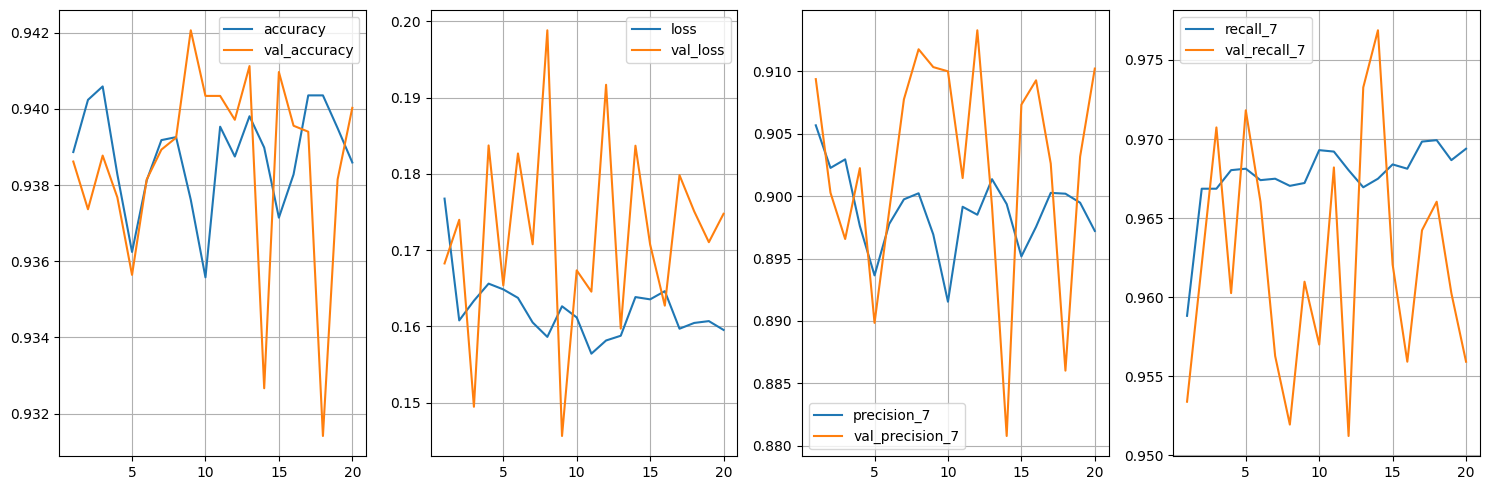

400/400 ━━━━━━━━━━━━━━━━━━━━ 1347s 3s/step - accuracy: 0.9394 - loss: 0.1545 - precision_7: 0.8988 - recall_7: 0.9690 - val_accuracy: 0.9400 - val_loss: 0.1748 - val_precision_7: 0.9102 - val_recall_7: 0.9559


In [17]:
#@tf.function
#def recall_loss(ground_truths, predictions):
#    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(ground_truths * predictions, 0, 1)))
#    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(ground_truths, 0, 1)))
#    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())    
#    CE = tf.keras.losses.binary_crossentropy(ground_truths, predictions)    
#    return -tf.math.log(recall) + CE

#model = load_model("models/resnet50v2_nn256_lr0001_relu_batch64_epoch30_v10_recallloss.keras", custom_objects={'recall_loss': recall_loss})
model = load_model("models/resnet50v2_nn256_lr0001_relu_batch64_epoch30_v11.keras", compile=False)
# Compile de model
optimizer = Adam(learning_rate=LEARN_RATE)
eval_metrics = [tf.keras.metrics.Precision(thresholds=0.5), tf.keras.metrics.Recall(thresholds=0.5), "accuracy"]
model.compile(optimizer=optimizer, loss=recall_loss, metrics=eval_metrics)
history = model.fit(
    train_generator,
    batch_size=BATCH_SIZE,    
    epochs=20,
    verbose=1,
    validation_data=validation_generator,    
    #class_weight=class_weight,
    callbacks=plot_learning()
)

In [18]:
model.save("models/resnet50v2_nn256_lr0001_relu_batch64_epoch70_v11.keras")

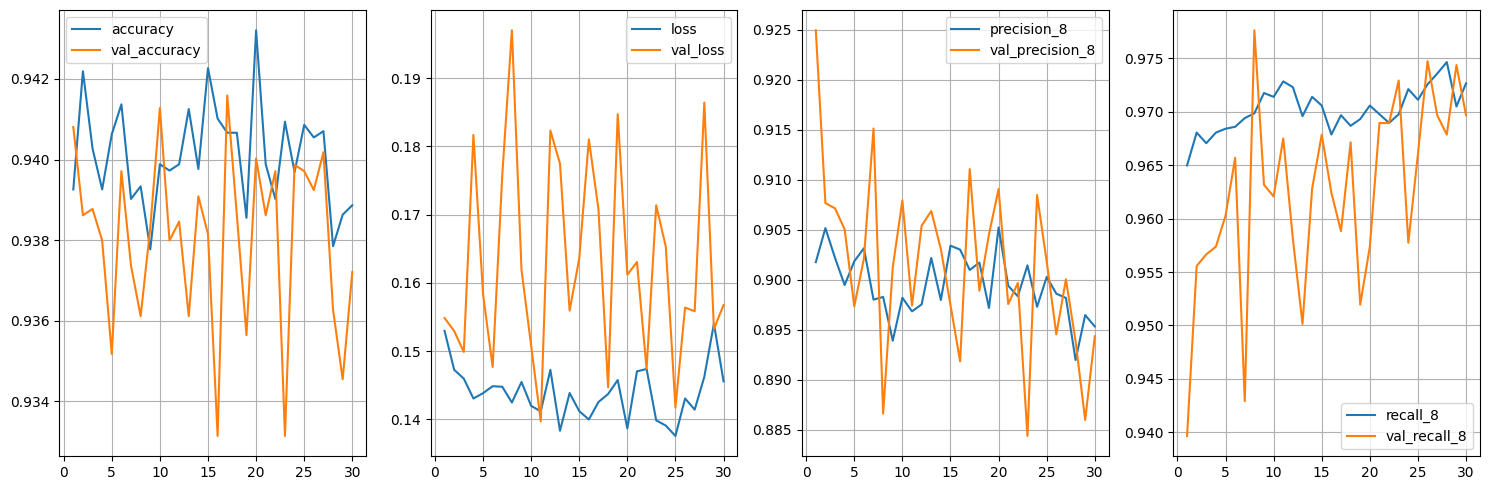

400/400 ━━━━━━━━━━━━━━━━━━━━ 1284s 3s/step - accuracy: 0.9385 - loss: 0.1443 - precision_8: 0.8938 - recall_8: 0.9732 - val_accuracy: 0.9372 - val_loss: 0.1568 - val_precision_8: 0.8944 - val_recall_8: 0.9697


In [19]:
#model = load_model("models/resnet50v2_nn256_lr0001_relu_batch64_epoch30_v10_recallloss.keras", custom_objects={'recall_loss': recall_loss})
model = load_model("models/resnet50v2_nn256_lr0001_relu_batch64_epoch70_v11.keras", compile=False)
# Compile de model
optimizer = Adam(learning_rate=LEARN_RATE)
eval_metrics = [tf.keras.metrics.Precision(thresholds=0.5), tf.keras.metrics.Recall(thresholds=0.5), "accuracy"]
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=eval_metrics)
history = model.fit(
    train_generator,
    batch_size=BATCH_SIZE,    
    epochs=30,
    verbose=1,
    validation_data=validation_generator,    
    #class_weight=class_weight,
    callbacks=plot_learning()
)

In [20]:
model.save("models/resnet50v2_nn256_lr0001_relu_batch64_epoch100_v11.keras")

In [6]:
# Print the model summary
model.summary()

output_shape = resnet_base.output_shape
print("Output shape of ResNet50V2 model:", output_shape)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 288, 288,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 294, 294,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 144, 144,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 146, 146,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 72, 72,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 72, 72,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 72, 72,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 72, 72,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 72, 72,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 72, 72,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 74, 74,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 72, 72,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 72, 72,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 72, 72,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 72, 72,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 72, 72,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 72, 72,    │          0 │ conv2_block1_0_c

 Total params: 150,968,325 (575.90 MB)

 Trainable params: 42,467,841 (162.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 84,935,684 (324.00 MB)

Output shape of ResNet50V2 model: (None, 9, 9, 2048)
